In [1]:
import geopandas as gpd
import fiona
import folium as fm
import pandas as pd
import numpy as np

import os, sys
import glob
from tqdm import tqdm

In [3]:
b = gpd.read_file("data/도로명주소_전자지도_2023_9월/11000/TL_SPBD_BULD.shp", encoding = 'cp949')

In [27]:
b['geometry'].sample(3)

203344    POLYGON ((958998.856 1955052.586, 958992.891 1...
571423    POLYGON ((968566.242 1949266.155, 968563.836 1...
539776    POLYGON ((959791.443 1947457.218, 959793.835 1...
Name: geometry, dtype: geometry

In [12]:
b.sample(3)

,BDTYP_CD,BD_MGT_SN,BSI_INT_SN,BSI_ZON_NO,BULD_MNNM,BULD_NM,BULD_NM_DC,BULD_SE_CD,BULD_SLNO,BUL_DPN_SE,...,MVM_RES_CD,NTFC_DE,OPERT_DE,POS_BUL_NM,RDS_MAN_NO,RDS_SIG_CD,RN_CD,SIG_CD,UND_FLO_CO,geometry
372064,01001,1150011000104210060001186,22660,07503,9,None,None,0,23,M,...,79,20110729,20170731140018,None,918,11500,4145107,11500,1,"POLYGON ((938108.983 1953862.695, 938102.194 1..."
138701,01003,1123010200101030030036783,21707,02585,6,None,None,0,0,M,...,71,20110729,20071213,None,2358,11230,4115520,11230,0,"POLYGON ((958760.993 1952878.618, 958761.193 1..."
568877,02003,1174010800103810028000001,4659,05374,60,None,None,0,0,M,...,71,20111116,20111020150341,None,83,11740,4172224,11740,0,"POLYGON ((967713.513 1948242.620, 967708.817 1..."


In [15]:
test = b[['BD_MGT_SN','BSI_ZON_NO','LNBR_MNNM','LNBR_SLNO',"EMD_CD"]].sample(5)

In [16]:
test

,BD_MGT_SN,BSI_ZON_NO,LNBR_MNNM,LNBR_SLNO,EMD_CD
66394,1117010700100240006024364,04334,24,6,107
483051,1162010200104710029014361,08704,471,29,102
132649,1123011000103320008003854,02451,332,8,110
447602,1156010300102350001034448,07253,235,0,103
473051,1162010200100920248022502,08783,92,246,102


In [19]:
test["BD_MGT_SN"]

/var/folders/nv/hhtvgb4j61l7czw1g2vm7pdc0000gn/T/ipykernel_49245/3254293256.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test["BD_MGT_SN"][5:3]


Series([], Name: BD_MGT_SN, dtype: object)

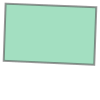

In [29]:
1117010700100240006 #66394 행의 건물 확인 # 서울 용산구 동자동 24-6

b[b.index==66394]['geometry'].values[0]